# Report

**By Will McFarland, 86184900**

**Topic: Job Ad Analysis**

## Introduction

The goal of this project is to scrape over 10'000 jobs to and apply Natural Language Processing functions to extract skill phrases from the text. We will search for 2 job titles and compare how similar or different the required skills for the jobs are.

## Workflow

There are 3 main steps to this project:

 1. Scraper: The code to scrape the job ads and record the url of the job ad, the job title, and the content of the job ad / job description. We also want to ensure that we are scraping unique ads to avoid duplicates. To get the job ads however, we need to generate search urls. For Indeed.com, this can be easily done by putting the search parameters in the URL, and using a for loop to generate a new URL for each page of ads.
 
 2. Pre-Processing: For the analysis to work as best as it can, we want to provide simple text with no unnecasary punctuation or symbols. We can remove all of this with a pre-processing script that will iterate through all of the raw job ads and output clean text. For more details on what exactly the pre-processing script does, see the comments in the `text_preprocessing.py` file.

3. NLP: The Natural Language Processing Functions are the core of this project. We want to process our job ads and extract the skill phrases for each job ad. The primary output of this step will be a CSV file with columns for the skill phrase, the job title, and the number of times that skill phrase appeared in job ads for each title.

These steps can be further broken down in the following flowchart that shows more clearly the inputs and outputs of each step:

![Flowchart](assets/flowchart.jpg)


## Defining Skills

In order to extract skills from the text, we need to define what exactly skills are. From the case study we looked at in class, we can use the following 3 syntactic patterns to define skills:

 1. Noun phrase (e.g., Java, ability to work independently, university degree, written communication)

 2. Verb phrase (e.g., develop web application, design software)

 3. Noun + Gerund (e.g., problem solving, web programming)

## Skill Extraction

My process is centered around [Natural Language Toolkit (NLTK) **Part-of-speech (POS) Tagging**](https://www.nltk.org/api/nltk.tag.html): This method was mentioned in the case study from class, and we can use it to tag phrases as what part of speech they are (noun, verb, etc.). From the tagged text, we can extract the syntactic skill patterns from the text to identify skills.

After the text has been tagged, we use another function called **chunking**, which uses entity and relation detection to identify our skill patterns that we defined above. Chunking takes in the tagged text, and returns chunks of the text that match our patterns.

After tagging and chunking, we finally pass the matching chunks to be **lemmatized**. This process is similar to stemming, but will standardize different forms of the same word. This will combine many similar results that are linguistically equivalent.

# Results

After obtaining the extracted skill phrases from the data, lets take a look at the results!

In [53]:
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,8)

In [23]:
preproc = pd.read_csv(filepath_or_buffer='data/processed_ads.csv', index_col=0, engine='python', skipinitialspace=True, quotechar="\"", quoting=1)
preproc[['title category','title']].groupby('title category', dropna=False).count().rename(columns={'title': 'count'})

,count
title category,
data engineer,8
data scientist/analyst,53
manager,6571
software developer,1230
software engineer,815
NaN,1472


Here is a breakdown of our data by job title. The search terms given to Indeeed were 'manager' and 'software developer'. Since 'software developer' is a relatively specific term, Indeed ended up returning a lot of results that were related to, but not exactly 'software developer', so I made the decision to narrow my results by their actual job title heading. As we can see in the above results, 1472 ads did not fall under any category, and only 1230 actually contained the words 'software developer' in the title. Because of this, I decided to add a couple categories for the next most common related job titles. 'Software Engineer' was nearly as common as 'Software Developer' so I decided to give it its own category. I am personally interested in data science and data engineer roles, so I added those our of interest.

With the preprocessing and job title categorization decisions out of the way, lets see the actual analysis results.

In [4]:
skill_counts = pd.read_csv(filepath_or_buffer='data/skill_counts.csv', index_col=0, engine='python', skipinitialspace=True, quotechar="\"", quoting=2).sort_values(by=['Count'], ascending=False)
skill_counts

,Title Category,Count
Skill,,
experience experience,manager,8254
work work,manager,6966
ability ability,manager,6848
team team,manager,5822
experience experience,NaN,4748
...,...,...
extant identifying,manager,1
exchange kte,manager,1
o staff,manager,1


This is a glance at what the analysis results look like. There are skill words, the job title category (software developer, manager, etc.), and the number of times that skill word occurs in ads for that job title category. For example "Experience" occured 8254 times in manager job ads. Unfortuntely there is an unresolved bug in the analysis functions where single-word noun phrases will duplicate themselves. We can ignore this and just pretend they outputted once.

The data contains a lot of false positives (phrases that are not skills). Using Excel, I did a bit of cleaning on the data to produce the top 30 skills for each job title category.

![Top 30 Manager Skills](assets/top30manager.jpg)
![Top 30 Software Developer Skills](assets/top30softdev.jpg)

From this data we can also graph these skills by the number of times they occured in ads for that job title.

![Manager Skills Graph](assets/managergraph.jpg)
![Software Developer Skills Graph](assets/softdevgraph.jpg)

Already, we can see a few of these skills overlapping between the two job titles. Lets take a look at exactly how much overlap there is.

For this, I will use the Jaccard Similarity Index which is accomplished simply in Python by taking the intersection of the two sets and dividing by their union (equal to their sum minus their intersection). Since this calculation requires the 2 sets be of the same size, we will just take a sample of the top 20'000 skill phrases from each set.

In [27]:
# Take the first 20'000 rows to get samples of equal shape (note that we sorted by count descending in the last step)
software_skills = skill_counts.loc[skill_counts['Title Category'] == 'software developer'].index[:20000]
manager_skills = skill_counts.loc[skill_counts['Title Category'] == 'manager'].index[:20000]

intersect = len(set(software_skills).intersection(set(manager_skills)))
jaccard = intersect / (len(software_skills) + len(manager_skills) - intersect)
print(f"{jaccard*100:.3f}%")

17.675%


Without an other processing, we find that the 2 sets are abount 18% similar. This seems like a moderate amount, not incredibly similar, but not entirely dissimilar either. Let's repeat for just the top 100 skills in each title category.

In [31]:
# Take the first 20'000 rows to get samples of equal shape (note that we sorted by count descending in the last step)
software_skills = skill_counts.loc[skill_counts['Title Category'] == 'software developer'].index[:100]
manager_skills = skill_counts.loc[skill_counts['Title Category'] == 'manager'].index[:100]

intersect = len(set(software_skills).intersection(set(manager_skills)))
jaccard = intersect / (len(software_skills) + len(manager_skills) - intersect)
print(f"{jaccard*100:.3f}%")

30.719%


As expected, the sets are slightly more similar as we look at fewer elements. In theory, this trend should be able to be extrapolated further...

Text(0, 0.5, 'Jaccard Similarity')

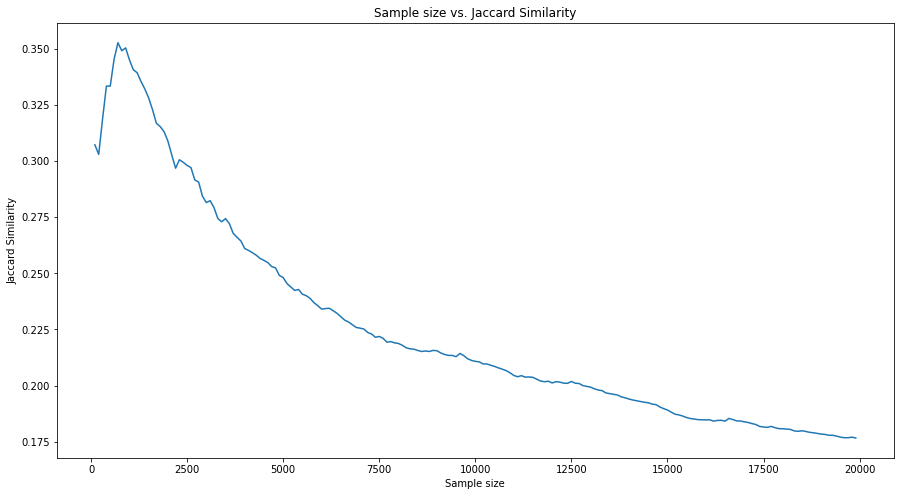

In [54]:
jaccs = []
x = range(100, 20000, 100)
for i in x:
    software_skills = skill_counts.loc[skill_counts['Title Category'] == 'software developer'].index[:i]
    manager_skills = skill_counts.loc[skill_counts['Title Category'] == 'manager'].index[:i]

    intersect = len(set(software_skills).intersection(set(manager_skills)))
    jaccs.append(intersect / (len(software_skills) + len(manager_skills) - intersect))

plt.plot(x, jaccs)
plt.title('Sample size vs. Jaccard Similarity')
plt.xlabel('Sample size')
plt.ylabel('Jaccard Similarity')

This is a really interesting plot because it confirms that just looking at fewer top skills generally yields higher similarity. From this, we can deduce that the most common skills from one job title are more likely to show up for other job titles. This isn't the most exciting conclusion, so lets move on to another graph that may provide more interesting results.

Lets add software engineer into the mix and see the relationships between those 3 job titles to see if we see the same result.

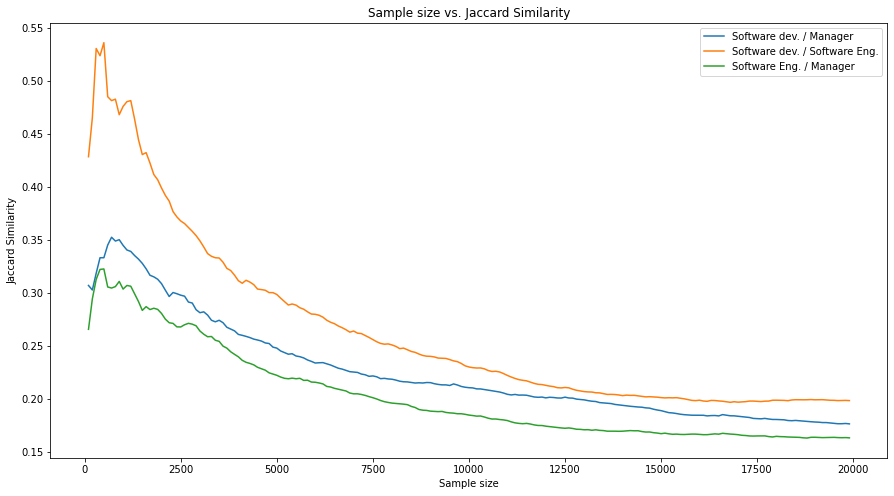

In [55]:
sd_m_jaccs = []
sd_se_jaccs = []
se_m_jaccs = []
x = range(100, 20000, 100)
for i in x:
    software_skills = skill_counts.loc[skill_counts['Title Category'] == 'software developer'].index[:i]
    manager_skills = skill_counts.loc[skill_counts['Title Category'] == 'manager'].index[:i]
    softeng_skills = skill_counts.loc[skill_counts['Title Category'] == 'software engineer'].index[:i]

    sd_m_intersect  = len(set(software_skills).intersection(set(manager_skills)))
    sd_se_intersect = len(set(software_skills).intersection(set(softeng_skills)))
    se_m_intersect  = len(set(softeng_skills).intersection(set(manager_skills)))
    
    sd_m_jaccs.append(sd_m_intersect / (len(software_skills) + len(manager_skills) - sd_m_intersect))
    sd_se_jaccs.append(sd_se_intersect / (len(software_skills) + len(softeng_skills) - sd_se_intersect))
    se_m_jaccs.append(se_m_intersect / (len(softeng_skills) + len(manager_skills) - se_m_intersect))

plt.plot(x, sd_m_jaccs, label='Software dev. / Manager')
plt.plot(x, sd_se_jaccs, label='Software dev. / Software Eng.')
plt.plot(x, se_m_jaccs, label='Software Eng. / Manager')

plt.title('Sample size vs. Jaccard Similarity')
plt.xlabel('Sample size')
plt.ylabel('Jaccard Similarity')
plt.legend()

As expected, it wasn't a fluke; we see the same trend with all 3 relationships.
Also, it comes as no surprise that software engineer and software developer are more similar to each-other than either are with manager. 

# Challenges/Shortcomings

The biggest challenge with this project was the scraping stage. First there was challenges with ratelimiting, where Indeed will return a Captcha if more than approximately 800 requests are sent in short succession. I was able to get around this by waiting a little bit between requests, and using a VPN to change my IP address to avoid wait times. Beyond that, the greater challenge was Indeed limiting the number of search results it can return to 1000 per search. So even if I had a search that claims it has 5'000 results, I will realistically only be able to fetch the first 1'000. There were a couple workaround here, namely sorting by date vs relavence, and setting different search distances would shuffle the results a little bit. In the end though, I ended up needing to broaden my search terms to reach 10'000 results, even if it meant that I wouldn't be getting that much more useful data. I did always ensure that the results I was getting were unique. The metric I used for uniqueness was the URL, which I later realized was an imperfect metric, as some ads had duplicate (or near-duplicate) job descriptions, but in different postings/URLs.

Another challenge I had was defining skills. As mentioned in the case study in class, there is very little research into this topic, so I essentially just used the example given in that case study but it proved to produce a lot of false positive results (words that were not skills).

I also realized in the analysis stage that 'Software Developer' may have been too specific of a term. Many of the results did not actually contain 'software developer' in the job title, which resulted in me having to exclude a lot of my data from the analysis.

**What I would do if I had more time...**

 - Look for more ads by broadening my geographic search area
 - Filter out duplicate or near-duplicate ad descriptions
 - Improve my chunking patterns to better catch skills
 - Choose a broader search term than 'software developer'